# 爬取学堂在线院校开设课程数量

In [15]:
from IPython.display import Image
import os
os.getcwd()

'd:\\000zyf\\Learning\\python_learn\\spider\\script\\练习\\学堂在线'

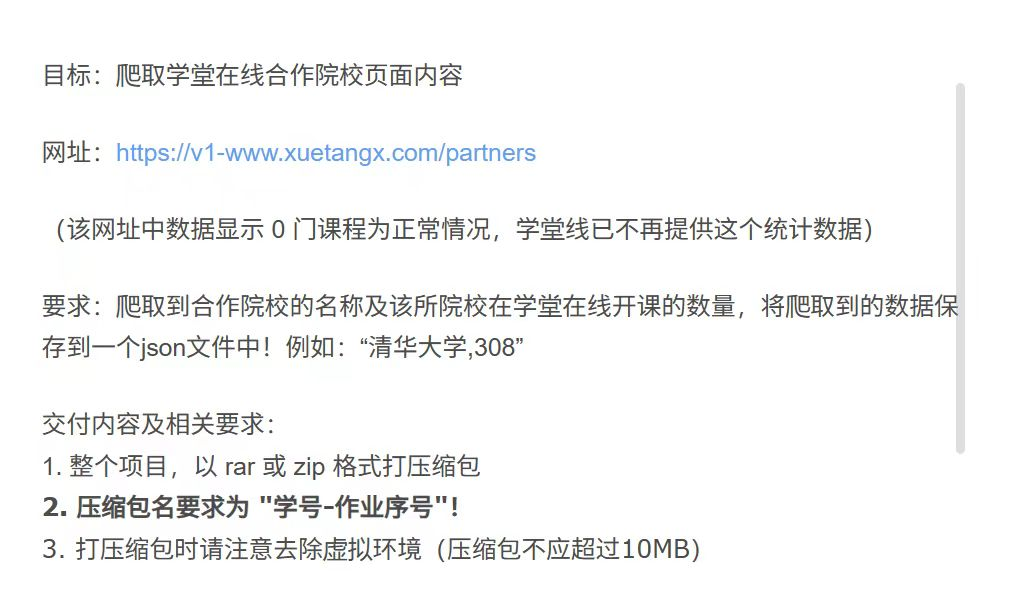

In [16]:
#要求
Image(filename="yaoqiu.jpg", width=500, height=200)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import os
import csv
import requests
import re
import logging

browser = webdriver.Chrome()#选择用chrome还是edge
# browser = webdriver.Edge()
School_List = {}
DOWNLOAD_PATH = 'images'
if not os.path.exists(DOWNLOAD_PATH):
    os.makedirs(DOWNLOAD_PATH)
    
def SaveMessage(browser,Schools_Infos):
    for school in Schools_Infos:
        school_name = school.find_element(By.CLASS_NAME, 'name_cn').text
        school_class_count = school.find_element(By.CLASS_NAME, 'count').text
        style_attribute = school.find_element(By.CLASS_NAME, 'logo').get_attribute('style')
        logo_url_match = re.search(r'url\("([^"]+)"\)', style_attribute)
        logo_url = logo_url_match.group(1) if logo_url_match else 'No logo found'
        ##motto被隐藏使用ActionChains执行悬停操作
        ActionChains(browser).move_to_element(school).perform()
        # 等待悬停后的元素（如motto）出现
        # 注意：这里的选择器".remark > span"需要根据实际情况调整
        try:
            WebDriverWait(school, 5).until(
                EC.visibility_of_element_located((By.CSS_SELECTOR, ".remark > span"))
            )
            school_motto = school.find_element(By.CSS_SELECTOR, ".remark > span").text
        except :
            school_motto='Nothing'
            print("Motto not found for this school, moving to the next.")
        
        ##保存school logo
        try:
            # 处理学校名称，确保其作为文件名是有效的
            safe_school_name = re.sub(r'[\\/*?:"<>|]', '', school_name)
            file_path = os.path.join(DOWNLOAD_PATH, safe_school_name + '.png')
            # 发送请求下载图像
            response = requests.get(logo_url)
            if response.status_code == 200:
                with open(file_path, 'wb') as file:
                    file.write(response.content)
                print(f"Logo for {school_name} saved successfully.")
            else:
                print(f"Failed to download logo for {school_name}.")
        except Exception as e:
            print(f"Error downloading logo for {school_name}: {e}")
        # print(school_name)
        # print(school_motto)
        # print(logo_url)
        School_List[school_name] = {
                'Course_count': school_class_count,
                'Motto': school_motto,
                'Logo_url':logo_url
            }

def SaveToCSV(School_List):
    with open('Schools_Info.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['School Name', 'Course Count', 'Motto', 'Logo Path'])
        for school, info in School_List.items():
            writer.writerow([school, info['Course_count'], info['Motto'], info['Logo_url']])


def getHTML(url,maxpage):
    try:
        currentpage=1
        browser.get(url)
        while currentpage<=maxpage:
            WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "school")))
            Schools_Infos = browser.find_elements(By.CLASS_NAME, 'school')
            SaveMessage(browser,Schools_Infos)
            # 尝试点击下一页
            try:
                next_button = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".btn-next")))
                next_button.click()
                currentpage+=1
            except Exception as e:
                print("No more pages or error occurred:", e)
                break
    finally:
        browser.quit()
        SaveToCSV(School_List)
        print("Data saved to CSV.")



def main():
    maxpage=2
    url='https://www.xuetangx.com/university/all'
    getHTML(url,maxpage)
    
if __name__=='__main__':
    main()

In [14]:
import logging

logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logging.warning('Admin logged out')